<h1 style="text-align:center; font-size:40px;">Birds Classification Project</h1>
<h2 style="text-align:center; font-size:20px;">Explore 525 Different Species</h2>
<p style="text-align: center"><img src="https://github.com/OdedReg/Birds-Classification/blob/main/Birds.jpg?raw=true"></p>

## Preprocessing

In [1]:
! pip install -U neptune-client lightning --quiet

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
aiobotocore 2.12.3 requires botocore<1.34.70,>=1.34.41, but you have botocore 1.34.93 which is incompatible.


In [2]:
import neptune
from neptune import Project
import pandas as pd
import numpy as np
import os
from PIL import Image
import time
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import pytorch_lightning as L
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms.functional as TF
from torchvision import transforms
from torchvision.io import read_image
from pytorch_lightning.loggers import NeptuneLogger
from pytorch_lightning.callbacks import LearningRateMonitor, ModelCheckpoint, ModelSummary, EarlyStopping
import torch.optim as optim
import sklearn
from sklearn import preprocessing
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.decomposition import IncrementalPCA
from sklearn.metrics import accuracy_score
import torch.utils.data as data
from torch.utils.data import Dataset,DataLoader, random_split
from tqdm import tqdm
import pickle
import xgboost as xgb
import warnings
import gc

# Suppress the specific warning
warnings.simplefilter('ignore', category=FutureWarning)
warnings.filterwarnings("ignore", message="The behavior of DataFrame concatenation with empty or all-NA entries is deprecated.*")

[neptune] [warning] NeptuneDeprecationWarning: The 'neptune-client' package has been deprecated and will be removed in the future. Install the 'neptune' package instead. For more, see https://docs.neptune.ai/setup/upgrading/


In [3]:
CHECKPOINT_PATH = os.environ.get("PATH_CHECKPOINT", "logs")
# Function for setting the seed
L.seed_everything(42)

torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")

Using cpu device


In [4]:
# Create checkpoint path if it doesn't exist yet
os.makedirs(CHECKPOINT_PATH, exist_ok=True)

In [5]:
file_path = "/kaggle/input/100-bird-species/birds.csv"
df = pd.read_csv(file_path)
df.head()

class id                      filepaths           labels data set  \
0       0.0  train/ABBOTTS BABBLER/001.jpg  ABBOTTS BABBLER    train   
1       0.0  train/ABBOTTS BABBLER/007.jpg  ABBOTTS BABBLER    train   
2       0.0  train/ABBOTTS BABBLER/008.jpg  ABBOTTS BABBLER    train   
3       0.0  train/ABBOTTS BABBLER/009.jpg  ABBOTTS BABBLER    train   
4       0.0  train/ABBOTTS BABBLER/002.jpg  ABBOTTS BABBLER    train   

        scientific name  
0  MALACOCINCLA ABBOTTI  
1  MALACOCINCLA ABBOTTI  
2  MALACOCINCLA ABBOTTI  
3  MALACOCINCLA ABBOTTI  
4  MALACOCINCLA ABBOTTI

In [6]:
# Change 'PARAKETT  AKULET' to the correct label 'PARAKETT  AUKLET'
df['labels'] = df['labels'].str.replace('PARAKETT  AKULET', 'PARAKETT  AUKLET')
df['filepaths'] = df['filepaths'].str.replace('PARAKETT  AKULET', 'PARAKETT  AUKLET')
df.loc[df['data set'] == 'valid', 'filepaths'] = df.loc[df['data set'] == 'valid', 'filepaths'].str.replace('PARAKETT  AUKLET', 'PARAKETT AUKLET')

# Concat Local Dataset path with filepaths
df['filepaths'] = '/kaggle/input/100-bird-species/' + df['filepaths']

# Labels transform to integers
df['class'] = df['class id'].astype(int)

# Splitting df to train, val and tesst
train_df = df[df['data set'] == 'train']
val_df = df[df['data set'] == 'valid'] 
test_df = df[df['data set'] == 'test']

In [7]:
df.head()

class id                                          filepaths  \
0       0.0  /kaggle/input/100-bird-species/train/ABBOTTS B...   
1       0.0  /kaggle/input/100-bird-species/train/ABBOTTS B...   
2       0.0  /kaggle/input/100-bird-species/train/ABBOTTS B...   
3       0.0  /kaggle/input/100-bird-species/train/ABBOTTS B...   
4       0.0  /kaggle/input/100-bird-species/train/ABBOTTS B...   

            labels data set       scientific name  class  
0  ABBOTTS BABBLER    train  MALACOCINCLA ABBOTTI      0  
1  ABBOTTS BABBLER    train  MALACOCINCLA ABBOTTI      0  
2  ABBOTTS BABBLER    train  MALACOCINCLA ABBOTTI      0  
3  ABBOTTS BABBLER    train  MALACOCINCLA ABBOTTI      0  
4  ABBOTTS BABBLER    train  MALACOCINCLA ABBOTTI      0

# Part 1 - EDA

In [8]:
def plot_image_example(index):
    """
    Display an example image from a DataFrame along with its associated label.

    Parameters:
        index (int): The index of the example image in the DataFrame.

    Returns:
        None
    """
    path = df.iloc[index]['filepaths']
    example_type = df.iloc[index]['labels']
    img_example = Image.open(os.path.join(path))
    plt.figure(figsize=(4, 3))
    plt.imshow(img_example)
    plt.title(example_type)
    plt.axis('off')  # Turn off axis
    plt.show()


def plot_multiple_imgs(df, title, nrow=2,ncol=2,figsize=(13,7),preds=None,skip=0):
    """
    Plot multiple images from a DataFrame.

    Parameters:
        df (DataFrame): The DataFrame containing image paths and labels.
        nrow (int): Number of rows in the grid of images.
        ncol (int): Number of columns in the grid of images.
        figsize (tuple): Size of the entire figure.
        preds (list, optional): List of predictions for the images. Default is None.
        skip (int, optional): Number of initial rows to skip in the DataFrame. Default is 0.

    Returns:
        None
    """
    fig,ax = plt.subplots(nrows=nrow,ncols=ncol,figsize=figsize)
    fig.subplots_adjust(hspace=0.1, wspace=0.1)
    if title:
        fig.suptitle(title, fontsize=24, fontweight='bold', y=0.93)
    for i in range(nrow*ncol):
        img = Image.open(df.iloc[i, 1])
        ax[i//ncol,i%ncol].imshow(img,cmap='binary')
        ax[i//ncol,i%ncol].set_xticks([])
        ax[i//ncol,i%ncol].set_yticks([])
        ax[i//ncol,i%ncol].text(0.05, 0.1, str(df.iloc[i, 2]), color='white',transform=ax[i//ncol,i%ncol].transAxes,weight='bold', fontsize=6,  bbox=dict(facecolor='black', alpha=0.7, edgecolor='none'))
    plt.show()


def get_class_dist(df, title):
    """
    Plot the distribution of labels/classes in a DataFrame.

    Parameters:
    - df (DataFrame): The DataFrame containing the labels.
    - title (str): The title for the plot.

    Returns:
    - None

    This function takes a DataFrame and a title as input, extracts the labels/classes from the DataFrame, 
    computes their counts, and plots the distribution using a bar plot.
    """
    labels = df['labels']
    label_counts = labels.value_counts()

    plt.figure(figsize=(18, 4))
    sns.barplot(x=label_counts.index, y=label_counts.values, palette='viridis', linewidth=0.1)
    plt.title(title)
    plt.xlabel('Labels')
    plt.ylabel('Count')
    plt.xticks([])
    plt.show()

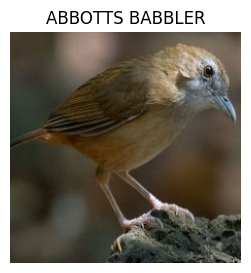

In [9]:
plot_image_example(12)

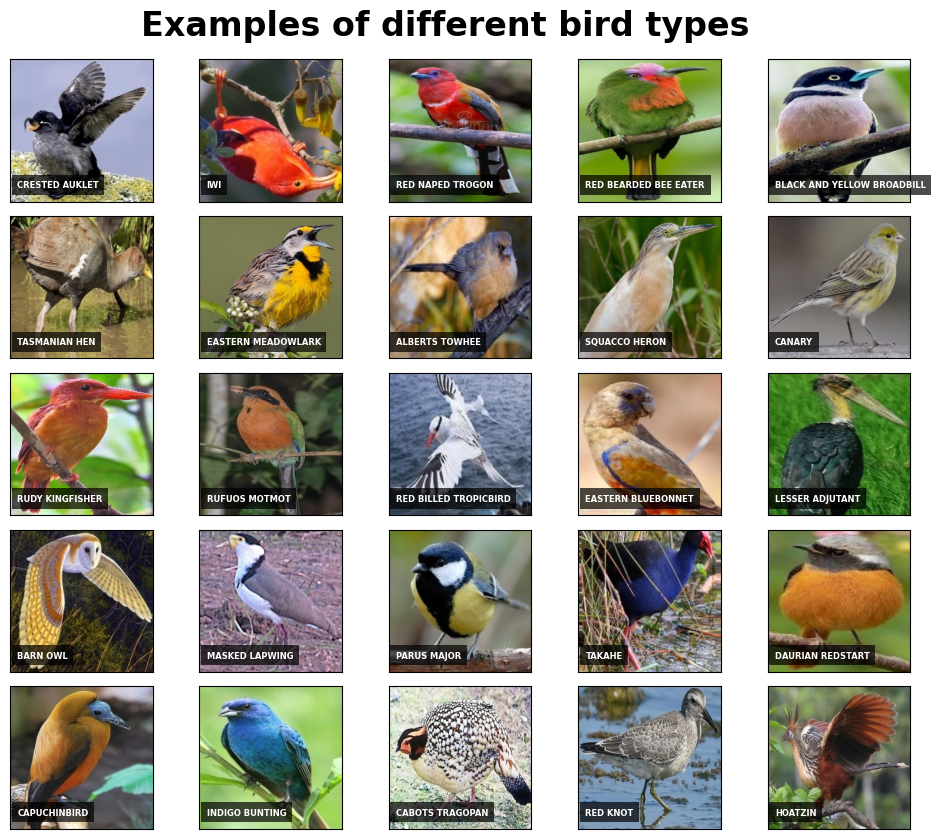

In [16]:
random_images = df.sample(25, random_state=49)
plot_multiple_imgs(random_images, "Examples of different bird types", 5,5,(12,10))

## a. Dimensionality of the data

In [18]:
print(f'Shape of the dataframe: {df.shape}\n')

split_values = df['data set'].value_counts()
path = df.iloc[0]['filepaths']
img_example = Image.open(os.path.join(path))
width, height = img_example.size

print('X_train shape is: {} \n\
y_train shape is: {}'.format((split_values['train'], width, height ),(split_values['train'], )))
print()
print('X_val shape is: {} \n\
y_val shape is: {}'.format((split_values['valid'], width, height ),(split_values['valid'], )))
print()
print('X_test shape is: {} \n\
y_test shape is: {}'.format((split_values['test'], width, height ),(split_values['test'], )))

Shape of the dataframe: (89885, 6)

X_train shape is: (84635, 224, 224) 
y_train shape is: (84635,)

X_val shape is: (2625, 224, 224) 
y_val shape is: (2625,)

X_test shape is: (2625, 224, 224) 
y_test shape is: (2625,)


## b.	What data does each sample contain?
    

In [64]:
mode= img_example.mode,  # Color mode (e.g., 'RGB')
size = img_example.size,  # Dimensions (width x height)
n_labels = df['labels'].nunique()
print(f'Each image has {mode[0]} mode, size of {size[0]} and one label out of {n_labels}')

Each image has RGB mode, size of (224, 224) and one label out of 525


## c. Class distribution

In [11]:
labels = df['labels']
label_counts = labels.value_counts()
n_birds = len(label_counts)
print(f'There are {n_birds} bird species in the dataset\n')
print(f'Labels count:\n\n {label_counts}')

There are 525 bird species in the dataset

Labels count:

 labels
RUFOUS TREPE               273
HOUSE FINCH                258
OVENBIRD                   243
D-ARNAUDS BARBET           243
ASIAN GREEN BEE EATER      230
                          ... 
SNOWY PLOVER               140
PATAGONIAN SIERRA FINCH    140
RED TAILED THRUSH          140
EURASIAN GOLDEN ORIOLE     140
NORTHERN RED BISHOP        140
Name: count, Length: 525, dtype: int64


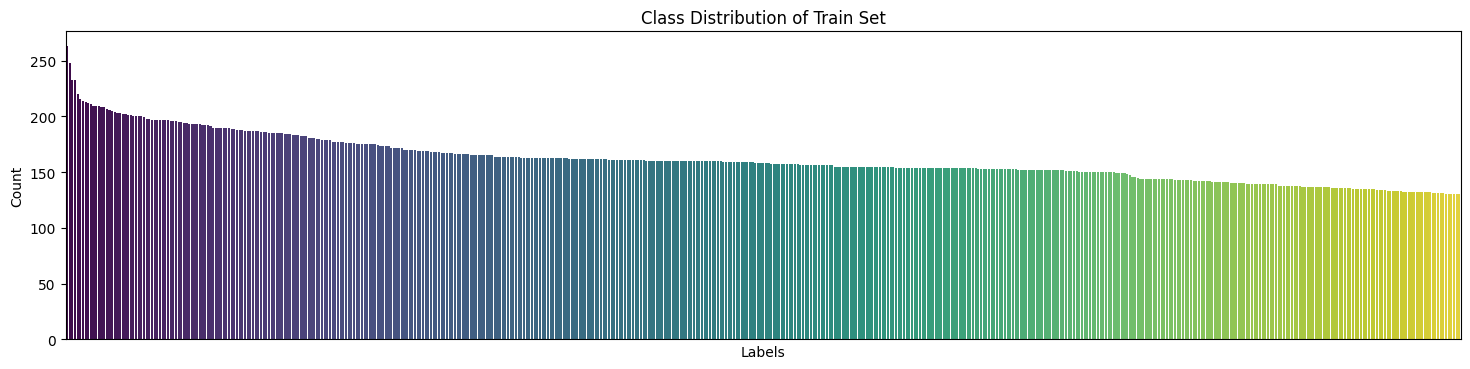

In [20]:
# Class Distribution of Train
get_class_dist(train_df, 'Class Distribution of Train Set')

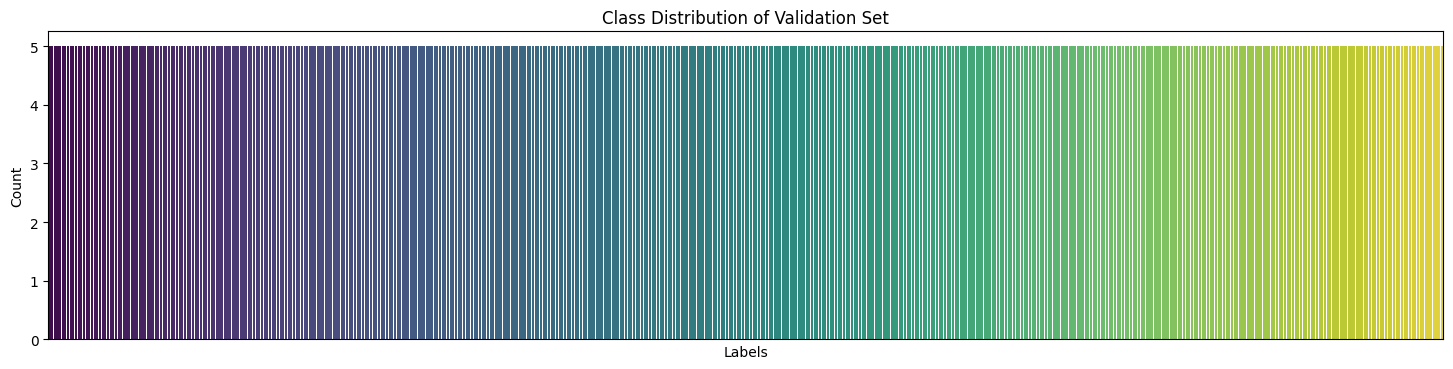

In [21]:
# Class Distribution of validation
get_class_dist(val_df, 'Class Distribution of Validation Set')

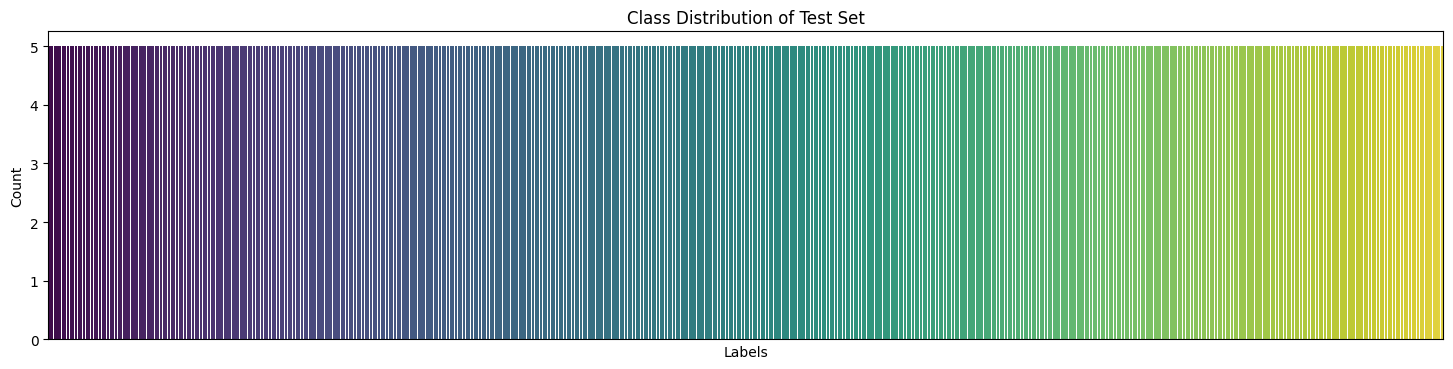

In [68]:
# Class Distribution of Test
get_class_dist(test_df, 'Class Distribution of Test Set')

#### The graph depict a balanced distribution in the validation and test set.

#### I aim to balance the training set by implementing oversampling. Each bird species will be represented by the maximum number of images found within the entire train_df dataset for that particular species (which is 267 images). If a species has fewer images than this maximum, I will randomly select images of that species to augment the dataset up to the maximum count. Since augmentation introduces variation, the duplicated images will not be identical.

## d. Benchmark

#### A benchmark of 99% accuracy has been achieved through transfer learning.

## e. Comparing hardly and easily separable bird species

### Hardly separable

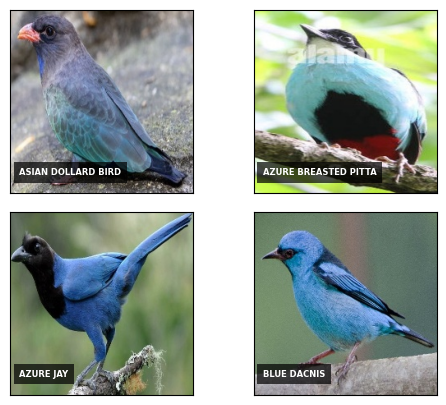

In [95]:
birds_to_show = random_samples_from_each_label(df,1)
birds_to_show = birds_to_show[birds_to_show['labels'].isin(['AZURE BREASTED PITTA', 'AZURE JAY', 'ASIAN DOLLARD BIRD', 'BLUE DACNIS'])]
plot_multiple_imgs(birds_to_show, False, 2,2,(6,5))

### Easily separable

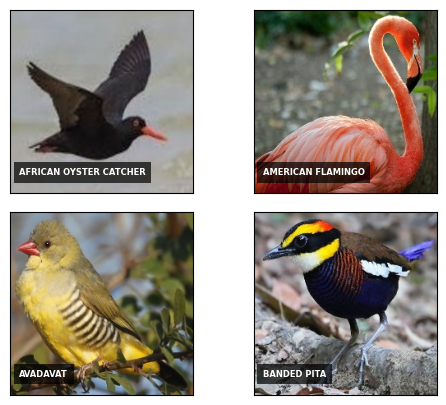

In [ ]:
birds_to_show = random_samples_from_each_label(df,1)
birds_to_show = birds_to_show[birds_to_show['labels'].isin(['AFRICAN OYSTER CATCHER', 'AVADAVAT', 'AMERICAN FLAMINGO','BARN OWL'])]
plot_multiple_imgs(birds_to_show,2,2,(6,5))

## f. Augmentation

### Calculate mean and std

In [8]:
class BirdsDataset(Dataset):
    def __init__(self, df, transform=None):
        self.df = df
        self.transform = transform

    def __getitem__(self, idx):
        image = Image.open(self.df.iloc[idx, 0])
        label = self.df.iloc[idx, 1]
        if self.transform is not None:
            image = self.transform(image)
        return image, label

    def __len__(self):
        return len(self.df)

In [10]:
def get_mean_and_std(dataloader):
    """
    Calculate the mean and standard deviation of pixel values in the dataset.

    Parameters:
        dataloader (DataLoader): A PyTorch DataLoader containing the dataset.

    Returns:
        tuple: A tuple containing the mean and standard deviation of pixel values.
    """
    # placeholders
    psum = torch.tensor([0.0, 0.0, 0.0])
    psum_sq = torch.tensor([0.0, 0.0, 0.0])

    # loop through images
    for inputs, labels in tqdm(dataloader):
        psum += inputs.sum(axis=[0, 2, 3])
        psum_sq += (inputs**2).sum(axis=[0, 2, 3])
        
    # pixel count
    count = len(df) * 224 * 224

    # mean and std
    total_mean = psum / count
    total_var = (psum_sq / count) - (total_mean**2)
    total_std = torch.sqrt(total_var)

    return total_mean, total_std
        
        
mean_std_df = df[['filepaths', 'class']]
mean_transform = transforms.Compose([transforms.Resize((224, 224)), transforms.ToTensor()])
image_dataset = BirdsDataset(mean_std_df, mean_transform)
image_loader  = DataLoader(image_dataset, batch_size=64, shuffle=False)
mean, std = get_mean_and_std(image_loader)
print("Mean: " + str(mean))
print("STD:  " + str(std))

Mean: [0.4742, 0.4694, 0.3954]
STD:  [0.2394, 0.2332, 0.2547]


In [11]:
# Define a list of augmentations
DATA_MEANS = [0.4742, 0.4694, 0.3954]
DATA_STD = [0.2394, 0.2332, 0.2547]

train_transform = transforms.Compose([
            transforms.RandomHorizontalFlip(),  
            transforms.RandomRotation(degrees=15),  
            transforms.RandomResizedCrop((224,224), scale=(0.8, 1.0), ratio=(0.9, 1.1)), 
            transforms.ToTensor(),  
            transforms.Normalize(DATA_MEANS, DATA_STD)
        ])

test_transform = transforms.Compose([transforms.Resize((224, 224)),
                                     transforms.ToTensor(),
                                     transforms.Normalize(DATA_MEANS, DATA_STD)])

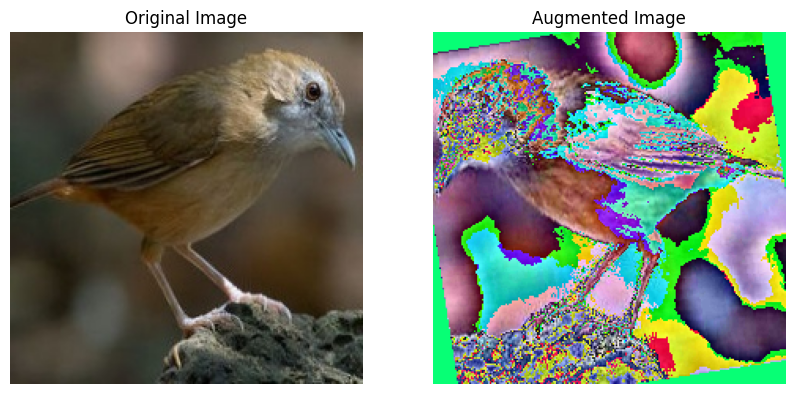

In [13]:
# Display original image vs augmented image
path = df.iloc[12]['filepaths']
img_example = Image.open(os.path.join(path))
augmented_image = train_transform(img_example)

augmented_image_np = TF.to_pil_image(augmented_image)

# Display the original and augmented images side by side
fig, axes = plt.subplots(1, 2, figsize=(10, 5))

axes[0].imshow(img_example)
axes[0].set_title('Original Image')
axes[0].axis('off')

axes[1].imshow(augmented_image_np)
axes[1].set_title('Augmented Image')
axes[1].axis('off')

plt.show()

# Part 2 - CNN

In [8]:
class BirdsDataset(Dataset):
    def __init__(self, df, transform=None):
        self.df = df
        self.transform = transform

    def __getitem__(self, idx):
        image = Image.open(self.df.iloc[idx, 0])
        label = self.df.iloc[idx, 1]
        if self.transform is not None:
            image = self.transform(image)
        return image, label

    def __len__(self):
        return len(self.df)

In [9]:
class BirdsDataModule(L.LightningDataModule):
    def __init__(self, train_data, val_data, test_data, batch_size=64):
        super().__init__()
        self.train_df = train_data
        self.val_df = val_data
        self.test_df = test_data
        self.batch_size = batch_size
        self.DATA_MEANS = [0.4742, 0.4694, 0.3954]
        self.DATA_STD = [0.2394, 0.2332, 0.2547]
        self.img_size = (224,224)
        
        # Define a list of augmentations
        self.train_transform = transforms.Compose([
            transforms.RandomHorizontalFlip(),  
            transforms.RandomRotation(degrees=15),  
            transforms.RandomResizedCrop((224,224), scale=(0.8, 1.0), ratio=(0.9, 1.1)), 
            transforms.ToTensor(),  
            transforms.Normalize(self.DATA_MEANS, self.DATA_STD)
        ])

        self.test_transform = transforms.Compose([transforms.Resize((224, 224)),
                                     transforms.ToTensor(),
                                     transforms.Normalize(self.DATA_MEANS, self.DATA_STD)])

    def train_dataloader(self):
        train_dataset = BirdsDataset(self.train_df, self.train_transform)
        return DataLoader(train_dataset, batch_size=self.batch_size, shuffle=True, num_workers=4)

    def val_dataloader(self):
        val_dataset = BirdsDataset(self.val_df, self.test_transform)
        return DataLoader(val_dataset, batch_size=self.batch_size, num_workers=4)

    def test_dataloader(self):
        test_dataset = BirdsDataset(self.test_df, self.test_transform)
        return DataLoader(test_dataset, batch_size=self.batch_size, num_workers=4)

In [10]:
class CNN(L.LightningModule):
    def __init__(self, model_hparams, optimizer_name, optimizer_hparams):
        """
        Inputs:
            model_hparams - Hyperparameters for the model, as dictionary.
            optimizer_name - Name of the optimizer to use. Currently supported: Adam, SGD
            optimizer_hparams - Hyperparameters for the optimizer, as dictionary. This includes learning rate, weight decay, etc.
        """
        super().__init__()
        
        # Exports the hyperparameters to a YAML file, and create "self.hparams" namespace
        self.save_hyperparameters()
        self.num_classes = model_hparams['num_classes']
        self.dropout = model_hparams['dropout']
        self.model_name = model_hparams['model_name']
        
        if self.model_name == 'ResNet34':
            self.features = torchvision.models.resnet34(pretrained=True)
            self.features = self.freeze_layers(self.features)
            self.features.fc = nn.Linear(self.features.fc.in_features, self.num_classes)
        elif self.model_name == 'DenseNet121':
            self.features = torchvision.models.densenet121(pretrained=True)
            self.features = self.freeze_layers(self.features)
            self.features.classifier = nn.Linear(self.features.classifier.in_features, self.num_classes)
            
        else:   # Regular CNN
            self.features = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Dropout(self.dropout),
            
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Dropout(self.dropout),
            
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Dropout(self.dropout),
            
            nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Dropout(self.dropout),
            
            nn.Conv2d(in_channels=256, out_channels=512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Dropout(self.dropout),
            )
        
            self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
            self.fc = nn.Linear(512, self.num_classes)
        
        # Create loss module
        self.loss_module = nn.CrossEntropyLoss()

    def freeze_layers(self, model):
        # Freeze all layers except the last one
        for param in model.parameters():
            param.requires_grad = False
        if self.model_name != 'DenseNet121':
            for param in model.fc.parameters():
                param.requires_grad = True
        else:
            for param in model.classifier.parameters():
                param.requires_grad = True
        return model
    
    def forward(self, x):
        x = self.features(x)
        if self.model_name == 'CNN':
            x = self.avgpool(x)
            x = torch.flatten(x,1)
            x = self.fc(x)
        return x

    def training_step(self, batch, batch_idx):
        imgs, labels = batch
        preds = self(imgs)
        loss = self.loss_module(preds, labels)
        acc = (preds.argmax(dim=-1) == labels).float().mean()

        # Logs the accuracy per epoch to tensorboard (weighted average over batches)
        self.log("train_acc", acc, on_step=False, on_epoch=True, logger=True, prog_bar=True)
        self.log("train_loss", loss, on_step=False, on_epoch=True, logger=True, prog_bar=True)
        return loss  

    def validation_step(self, batch, batch_idx):
        imgs, labels = batch
        preds = self(imgs)
        loss = self.loss_module(preds, labels)
        acc = (preds.argmax(dim=-1) == labels).float().mean()
        # By default logs it per epoch (weighted average over batches)
        self.log("val_acc", acc, prog_bar=True)
        self.log("val_loss", loss, prog_bar=True)

    def test_step(self, batch, batch_idx):
        imgs, labels = batch
        preds = self(imgs)
        loss = self.loss_module(preds, labels)
        acc = (preds.argmax(dim=-1) == labels).float().mean()
        # By default logs it per epoch (weighted average over batches), and returns it afterwards
        self.log("test_acc", acc, prog_bar=True)
        self.log("test_loss", loss, prog_bar=True)
        
    def configure_optimizers(self):
        # We will support Adam or SGD as optimizers.
        if self.hparams.optimizer_name == "Adam":
            # AdamW is Adam with a correct implementation of weight decay (see here
            optimizer = optim.AdamW(self.parameters(), **self.hparams.optimizer_hparams)
        else:
            assert False, f'Unknown optimizer: "{self.hparams.optimizer_name}"'

        # We will reduce the learning rate by 0.1 after 100 and 150 epochs
        scheduler = optim.lr_scheduler.MultiStepLR(optimizer, milestones=[50,100], gamma=0.1)
        return [optimizer], [scheduler]

In [11]:
def train_model(model_name, cp_path, batch_size, max_epochs, train_df, val_df, test_df, save_name=None, **kwargs):
    """
    Train a specified model on the provided data.

    Args:
    - model_name (str): Name of the model to run.
    - cp_path (str): Path to the checkpoint file for pretrained model. If None, trains from scratch.
    - batch_size (int): Batch size for training.
    - max_epochs (int): Maximum number of epochs for training.
    - train_df (DataFrame): DataFrame containing training data.
    - val_df (DataFrame): DataFrame containing validation data.
    - test_df (DataFrame): DataFrame containing test data.
    - save_name (str, optional): Name for saving checkpoints and logs. If None, defaults to model_name.

    Returns:
    - model: Trained model instance.
    - result (dict): Dictionary containing test accuracy and validation accuracy (if applicable).
    - best_model_path (str): Path to the best model checkpoint.
    """
    if save_name is None:
        save_name = model_name

    # Create a PyTorch Lightning trainer with the generation callback
    cp_callback  = ModelCheckpoint(
                save_weights_only=True, mode="min", monitor="val_loss")

    early_stop_callback = EarlyStopping(
                monitor='val_loss',  # Monitor validation loss for improvement
                min_delta=0.001,      # Minimum change in monitored quantity to qualify as an improvement
                patience=4,           # Number of epochs with no improvement after which training will be stopped
                verbose=False          # Print early stopping information
                )

    neptune_logger = NeptuneLogger(
    project="odedreg/Assignment3",
    name=f'Find-HyperParams {model_name}',
    tags=[f'Find-HyperParams {model_name}'],
    api_token="",
    log_model_checkpoints=False,
    )

    trainer = L.Trainer(
        default_root_dir=os.path.join(CHECKPOINT_PATH, save_name),  # Where to save models
        # We run on a single GPU (if possible)
        accelerator="auto",
        logger=neptune_logger,
        # How many epochs to train for if no patience is set
        max_epochs=max_epochs,
        callbacks=[early_stop_callback,
            cp_callback,  # Save the best checkpoint based on the maximum val_acc recorded. Saves only weights and not optimizer
            LearningRateMonitor("epoch"),
        ],  # Log learning rate every epoch
    )  # In case your notebook crashes due to the progress bar, consider increasing the refresh rate

    trainer.logger._log_graph = True  # If True, we plot the computation graph in tensorboard
    trainer.logger._default_hp_metric = None  # Optional logging argument that we don't need

    model_hparams = kwargs.get('model_hparams')
    optimizer_name = kwargs.get('optimizer_name')
    optimizer_name = {'optimizer_name': optimizer_name}
    optimizer_hparams = kwargs.get('optimizer_hparams')

    all_hyperparams = {**model_hparams, **optimizer_name, **optimizer_hparams}
    neptune_logger.log_hyperparams(params=all_hyperparams)

    # Check whether pretrained model exists. If yes, load it and skip training
    if cp_path != None:
        print(f"Found pretrained model at {cp_path}, loading...")
        # Automatically loads the model with the saved hyperparameters
        model = CNN.load_from_checkpoint(cp_path)
    else:
        model = CNN(**kwargs)

    dm = BirdsDataModule(train_df, val_df, test_df, batch_size=batch_size)
    trainer.fit(model, dm)

    model = CNN.load_from_checkpoint(
          trainer.checkpoint_callback.best_model_path
      )  # Load best checkpoint after training

    # Test best model on validation and test set

    test_result = trainer.test(model, dataloaders=dm.test_dataloader(), verbose=False)
    val_result = trainer.test(model, dataloaders=dm.val_dataloader(), verbose=False)
    result = {"test_loss": test_result[0]["test_loss"], "val_loss": val_result[0]["test_loss"],
             "test_acc": test_result[0]["test_acc"], "val_acc": val_result[0]["test_acc"]}
    return model, result, cp_callback.best_model_path, neptune_logger

In [12]:
def test_model(model_name, cp_path, batch_size, max_epochs, train_df, val_df, test_df, model_hparams, optimizer_name, optimizer_hparams):
    """
    Perform Training and Evaluation on the provided data, measures time and clear cache from cuda

    Args:
    - model_name (str): Name of the model to run.
    - cp_path (str): Path to the checkpoint file for pretrained model. If None, trains from scratch.
    - batch_size (int): Batch size for training.
    - max_epochs (int): Maximum number of epochs for training.
    - train_df (DataFrame): DataFrame containing training data.
    - val_df (DataFrame): DataFrame containing validation data.
    - test_df (DataFrame): DataFrame containing test data.
    - model_hparams (dict): Hyperparameters for the model.
    - optimizer_name (str): Name of the optimizer to use. Supported options: "Adam", "SGD".
    - optimizer_hparams (dict): Hyperparameters for the optimizer.

    Returns:
    - chosen_model: Trained model instance.
    - model_results (dict): Dictionary containing test accuracy and validation accuracy (if applicable).
    - cp_path_new (str): Path to the best model checkpoint.
    - total_time (float): Total time taken for training and evaluation.
    """
    t = time.time()
    chosen_model, model_results, cp_path_new, neptune_logger = train_model(
    model_name=model_name,
    cp_path = cp_path,
    batch_size = batch_size,
    max_epochs = max_epochs,
    train_df = train_df,
    val_df = val_df,
    test_df = test_df,
    model_hparams=model_hparams,
    optimizer_name = optimizer_name,
    optimizer_hparams = optimizer_hparams
    )

    total_time = time.time() - t
    neptune_logger.experiment.stop()
    torch.cuda.empty_cache()

    return (chosen_model, model_results, cp_path_new, total_time)

In [13]:
def get_params_list(dropout_list, lr_list, weight_decay_list, model_name):
    """
    Generate a list of parameter combinations for training the model.

    Args:
    - dropout_list (list): List of dropout values to try.
    - lr_list (list): List of learning rates to try.
    - weight_decay_list (list): List of weight decay values to try.

    Returns:
    - params_list (list): List of tuples, each containing a dictionary of model hyperparameters,
      the optimizer name, and a dictionary of optimizer hyperparameters.
    """
    params_list = []
    for dropout_value in dropout_list:
        for lr_value in lr_list:
            for weight_decay_value in weight_decay_list:
                  params_list.append(({'num_classes': 525,
                                       'model_name': model_name,
                                        'dropout' : dropout_value},
                                      "Adam",
                                      {"lr": lr_value,
                                       "weight_decay": weight_decay_value}))
    return params_list

In [14]:
def grid_search(params_list, X_train_grid, X_val_grid, X_test_grid, model_name, batch_size, max_epochs):
    """
    Perform grid search over the provided parameter combinations.

    Args:
    - params_list (list): List of parameter combinations, each containing model hyperparameters,
    optimizer name, and optimizer hyperparameters.
    - max_epochs (int): Maximum number of epochs for training.

    Returns:
    - hyper_params_list (list): List of tuples, each containing a string representation of the
    hyperparameters and the corresponding validation accuracy.
    """
    hyper_params_list = []
    for config in params_list:
        model_hparams = config[0]
        optimizer_name = config[1]
        optimizer_hparams = config[2]
        chosen_model, model_results, cp_path_new, total_time = test_model(
        model_name = model_name,
        cp_path = None,
        batch_size = batch_size,
        max_epochs = max_epochs,
        train_df = X_train_grid,
        val_df = X_val_grid,
        test_df = X_test_grid,
        model_hparams = model_hparams,
        optimizer_name = optimizer_name,
        optimizer_hparams = optimizer_hparams,
        )
        acc_results_val = model_results['val_loss']
        hyper_params_list.append((f"params:\n{model_hparams}\n{optimizer_hparams},  validation loss: {np.round(acc_results_val,3)}\n", np.round(acc_results_val,3)))
    return hyper_params_list

In [15]:
def print_grid_search(hyper_params_list):
    """
    Print the results of the grid search and the best hyperparameters found.

    Args:
    - hyper_params_list (list): List of tuples, each containing a string representation of the
    hyperparameters and the corresponding validation accuracy.
    """
    best_hyper_params = min(hyper_params_list, key=lambda item: item[1])[0]
    print(f'\nBest hyperparameters: {best_hyper_params}\n')
    print('Grid Search results:')
    for x in hyper_params_list:
        print(x[0])

In [16]:
def print_results(results):
    """
    Print model results.

    Args:
        results (dict): A dictionary containing model results with keys:
                        - 'test_loss': Test loss value
                        - 'test_acc': Test accuracy value
    Returns:
        None
    """
    print("Model Results:\n")
    print("Test Loss:", results.get('test_loss'))
    print("Test Accuracy:", results.get('test_acc'))


In [17]:
def sample_or_duplicate(group, n_samples):
    """
    Sample or duplicate rows within a group to match a desired number of samples.

    Parameters:
        group (DataFrame): A DataFrame representing a group.
        n_samples (int): The desired number of samples for the group.

    Returns:
        DataFrame: A DataFrame containing the sampled or duplicated rows to match the desired number of samples.
    """
    if len(group) == n_samples:
        return group
    else:
        num_duplicates = n_samples // len(group)
        remainder = n_samples % len(group)
        duplicated = pd.concat([group] * num_duplicates + [group.sample(n=remainder, replace=False, random_state=42)])
        return duplicated

def oversample_df(df):
    """
    Oversample a DataFrame by duplicating or sampling rows within each group.

    Parameters:
        df (DataFrame): The input DataFrame containing groups to oversample.

    Returns:
        DataFrame: A new DataFrame with oversampled rows, where each group contains the same number of samples.
    """
    # Apply the function to each group and concatenate the results
    new_dfs = []
    n_samples = df.groupby('class').size().max()
    for activity, group in df.groupby('class'):
        new_dfs.append(sample_or_duplicate(group, n_samples))

    # Concatenate the results into a new DataFrame
    new_df = pd.concat(new_dfs)

    # Reset the index
    new_df.reset_index(drop=True, inplace=True)
    return new_df

In [18]:
def downsample_df(df, n):
    """
    Downsamples a DataFrame by randomly selecting 'n' samples from each group.

    Parameters:
    -----------
    df : pandas.DataFrame
        The DataFrame to be downsampled.
    n : int
        The number of samples to be selected from each group.

    Returns:
    --------
    pandas.DataFrame
        A downsampled DataFrame containing 'n' samples from each group.

    Notes:
    ------
    This function groups the DataFrame by the 'class' column and randomly selects 'n' samples from each group.
    If a group has fewer than 'n' samples, all samples from that group are selected.
    """
    # Group the DataFrame by the classes
    grouped_df = df.groupby('class')

    # Initialize an empty DataFrame to store the sampled data
    new_df = pd.DataFrame()

    # Sample 'n' rows from each group and concatenate them
    for group, data in grouped_df:
        sampled_data = data.sample(n=min(n, len(data)), replace=False)
        new_df = pd.concat([new_df, sampled_data])

    # Reset the index of the resulting DataFrame
    new_df.reset_index(drop=True, inplace=True)

    return new_df

# Undersampling train df
train_df_undersample = downsample_df(train_df, 10)

### Coarse to fine-tune Grid Search

In [77]:
# Select relevant columns
train_df_undersample = train_df_undersample[['filepaths', 'class']]
val_df = val_df[['filepaths', 'class']]
test_df = test_df[['filepaths', 'class']]

### Expirment 1: 

#### Compare dropout_list = [0, 0.3], lr_list = [1e-3, 1e-4] and weight_decay_list = [0.001, 0.01]

In [ ]:
dropout_list = [0, 0.3]
lr_list = [1e-3, 1e-4]
weight_decay_list = [0.001, 0.01]
params_list = get_params_list(dropout_list, lr_list, weight_decay_list, 'CNN')
hyper_params_list1 = grid_search(params_list, train_df_undersample, val_df, test_df, "CNN_grid_search",128, 10)

In [19]:
print_grid_search(hyper_params_list1)


Best hyperparameters: params:
{'num_classes': 525, 'dropout': 0}
{'lr': 0.001, 'weight_decay': 0.01},  validation loss: 5.029


Grid Search results:
params:
{'num_classes': 525, 'dropout': 0}
{'lr': 0.001, 'weight_decay': 0.001},  validation loss: 5.084

params:
{'num_classes': 525, 'dropout': 0}
{'lr': 0.001, 'weight_decay': 0.01},  validation loss: 5.029

params:
{'num_classes': 525, 'dropout': 0}
{'lr': 0.0001, 'weight_decay': 0.001},  validation loss: 5.384

params:
{'num_classes': 525, 'dropout': 0}
{'lr': 0.0001, 'weight_decay': 0.01},  validation loss: 5.413

params:
{'num_classes': 525, 'dropout': 0.3}
{'lr': 0.001, 'weight_decay': 0.001},  validation loss: 5.279

params:
{'num_classes': 525, 'dropout': 0.3}
{'lr': 0.001, 'weight_decay': 0.01},  validation loss: 5.182

params:
{'num_classes': 525, 'dropout': 0.3}
{'lr': 0.0001, 'weight_decay': 0.001},  validation loss: 5.925

params:
{'num_classes': 525, 'dropout': 0.3}
{'lr': 0.0001, 'weight_decay': 0.01},  validation loss: 5

### Runs 130-137

### Loss Comparsion:

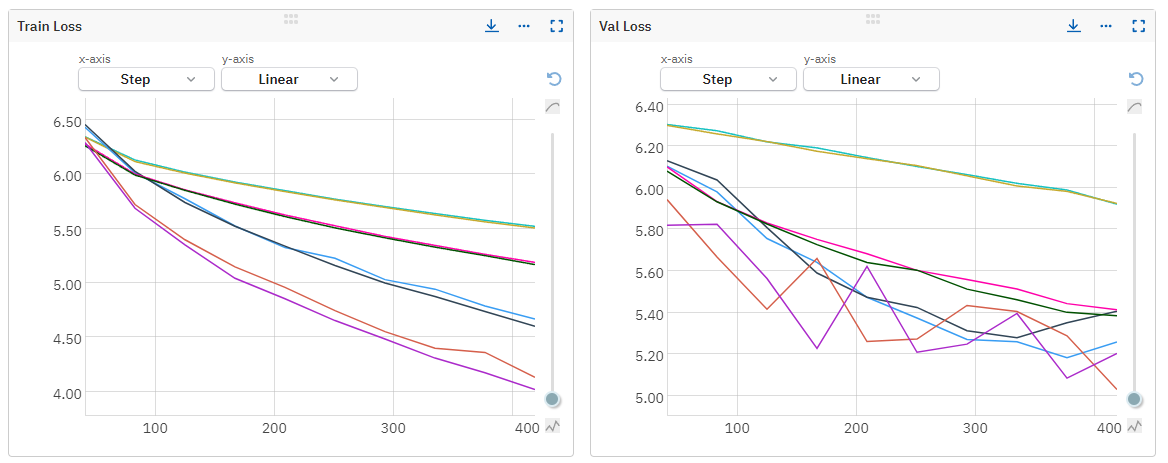

### Accuracy Comparsion:

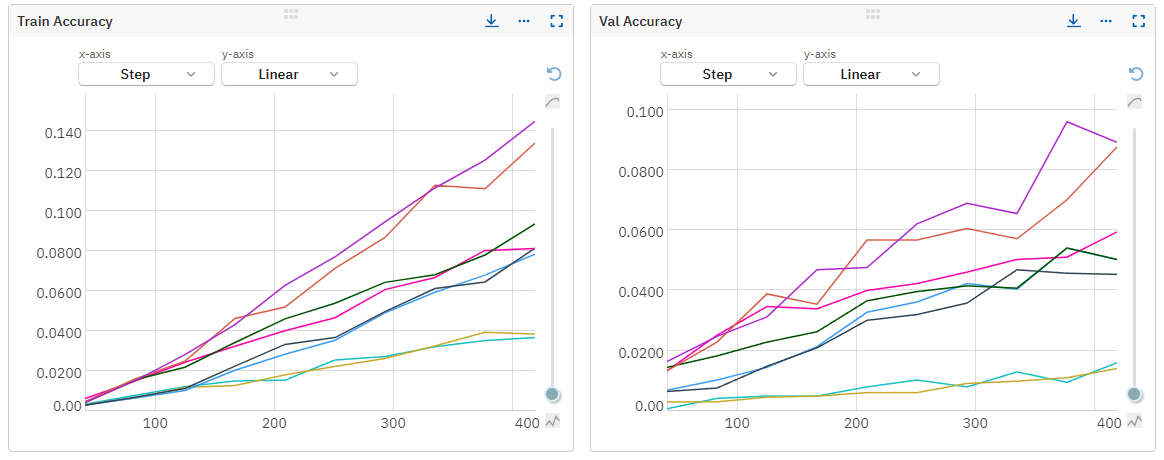

### Expirment 2: 

#### For further evaluation, I will examine the difference of the weight_decay_list = [0.001, 0.01]

In [23]:
# Undersampling train df
train_df_undersample = downsample_df(train_df, 30)

# Select relevant columns
train_df_undersample = train_df_undersample[['filepaths', 'class']]
val_df = val_df[['filepaths', 'class']]
test_df = test_df[['filepaths', 'class']]

In [ ]:
dropout_list = [0]
lr_list = [1e-3]
weight_decay_list = [0.001, 0.01]
params_list = get_params_list(dropout_list, lr_list, weight_decay_list, 'CNN')
hyper_params_list2 = grid_search(params_list, train_df_undersample, val_df, test_df, "CNN_grid_search",128, 10)

In [25]:
print_grid_search(hyper_params_list2)


Best hyperparameters: params:
{'num_classes': 525, 'dropout': 0}
{'lr': 0.001, 'weight_decay': 0.001},  validation loss: 3.215


Grid Search results:
params:
{'num_classes': 525, 'dropout': 0}
{'lr': 0.001, 'weight_decay': 0.001},  validation loss: 3.215

params:
{'num_classes': 525, 'dropout': 0}
{'lr': 0.001, 'weight_decay': 0.01},  validation loss: 3.435



### Runs 139-140

### Loss Comparsion:

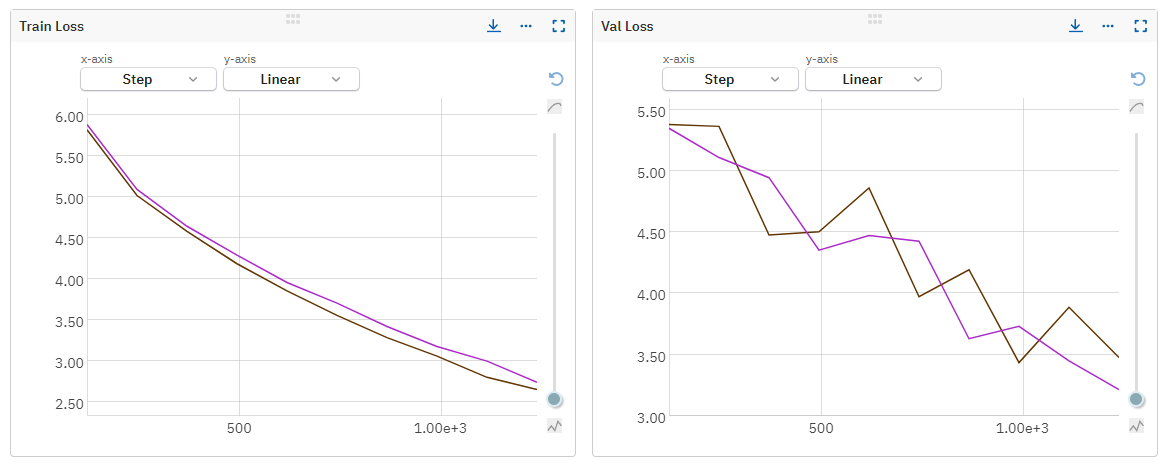

### Accuracy Comparsion:

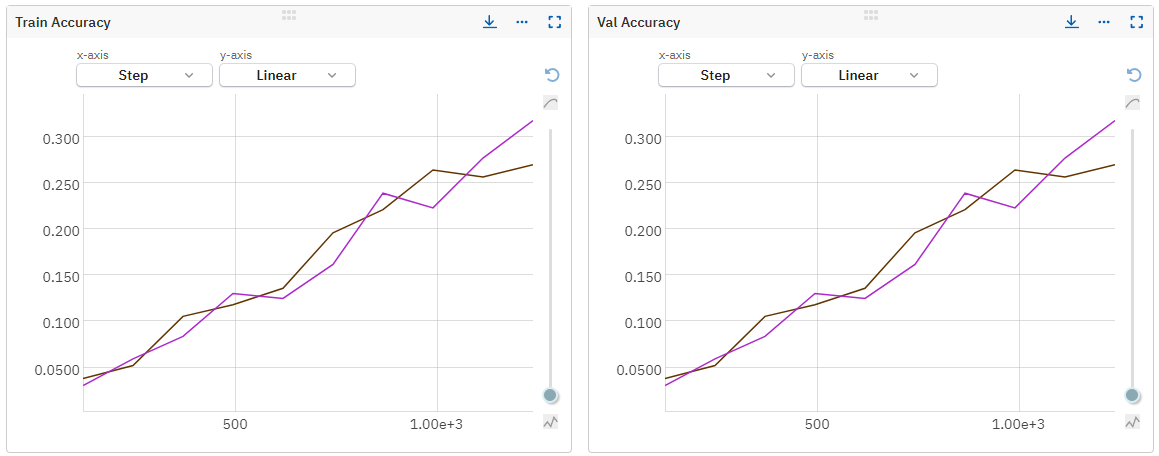

### Expirment 3: 

#### Final training with chosen Hyper-Parameters - "learing rate": 1e-3, "weight decay": 0.001 and "dropout": 0

In [35]:
# Concatenate train_df and val_df
train_df = pd.concat([train_df, val_df], ignore_index=True)

# Resetting index (optional)
train_df.reset_index(drop=True, inplace=True)

# Oversampling train df
oversample_train_df = oversample_df(train_df)

# Select relevant columns
oversample_train_df = oversample_train_df[['filepaths', 'class']]
test_df = test_df[['filepaths', 'class']]

In [ ]:
chosen_model_cnn, model_results_cnn, cp_path_new_cnn, total_time_cnn = test_model(
    model_name="CNN",
    cp_path = None,
    batch_size = 128,
    max_epochs = 20,
    train_df = oversample_train_df,
    val_df = test_df,
    test_df = test_df,
    model_hparams={'model_name':'CNN', 'num_classes':525, 'dropout': 0},
    optimizer_name = "Adam",
    optimizer_hparams = {"lr": 1e-3, "weight_decay": 0.001},
)

In [71]:
print_results(model_results_cnn)

Model Results:

Test Loss: 0.4440692067146301
Test Accuracy: 0.8864762187004089


In [72]:
torch.save(chosen_model_cnn, "/kaggle/working/cnn_model.pth")

### Run 165

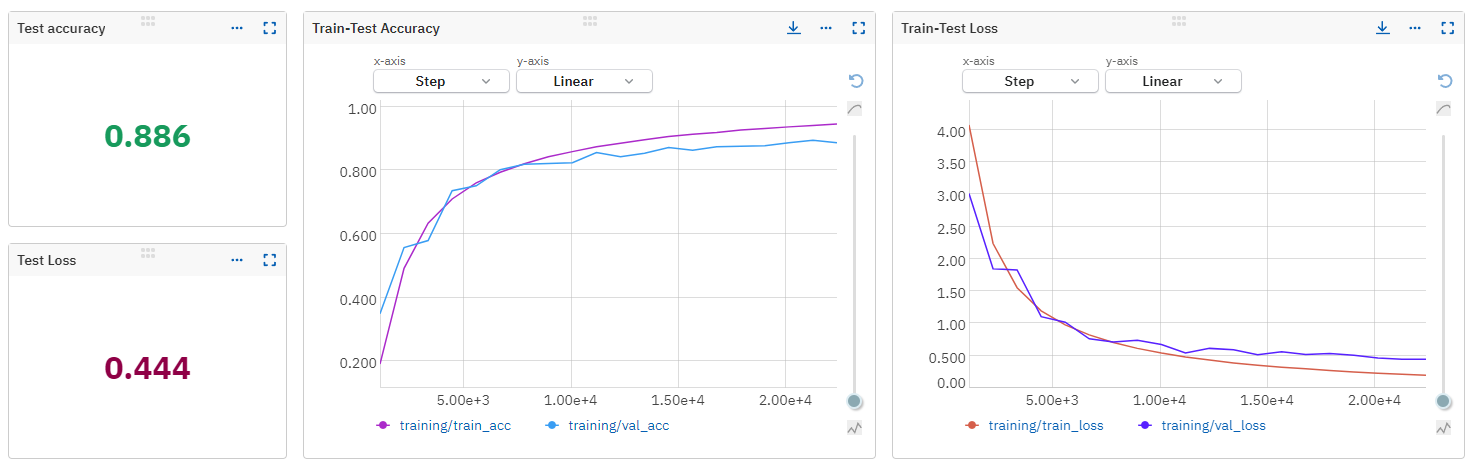

# Part 3 - Transfer Learning

## a. ResNet34

In [ ]:
dropout_list = [0, 0.3]
lr_list = [1e-3, 1e-4]
weight_decay_list = [0.001, 0.01]
params_list = get_params_list(dropout_list, lr_list, weight_decay_list, 'ResNet34')
hyper_params_list_resnet = grid_search(params_list, train_df_undersample, val_df, test_df, "ResNet_grid_search",128, 10)

In [93]:
print_grid_search(hyper_params_list_resnet)


Best hyperparameters: params:
{'num_classes': 525, 'model_name': 'ResNet34', 'dropout': 0.3}
{'lr': 0.001, 'weight_decay': 0.001},  validation loss: 1.652


Grid Search results:
params:
{'num_classes': 525, 'model_name': 'ResNet34', 'dropout': 0}
{'lr': 0.001, 'weight_decay': 0.001},  validation loss: 1.663

params:
{'num_classes': 525, 'model_name': 'ResNet34', 'dropout': 0}
{'lr': 0.001, 'weight_decay': 0.01},  validation loss: 1.672

params:
{'num_classes': 525, 'model_name': 'ResNet34', 'dropout': 0}
{'lr': 0.0001, 'weight_decay': 0.001},  validation loss: 5.136

params:
{'num_classes': 525, 'model_name': 'ResNet34', 'dropout': 0}
{'lr': 0.0001, 'weight_decay': 0.01},  validation loss: 5.104

params:
{'num_classes': 525, 'model_name': 'ResNet34', 'dropout': 0.3}
{'lr': 0.001, 'weight_decay': 0.001},  validation loss: 1.652

params:
{'num_classes': 525, 'model_name': 'ResNet34', 'dropout': 0.3}
{'lr': 0.001, 'weight_decay': 0.01},  validation loss: 1.662

params:
{'num_classes': 52

#### Final training with chosen Hyper-Parameters - "learing rate": 1e-3, "weight decay": 0.001 and "dropout": 0.3

In [ ]:
chosen_model_ResNet34, model_results_ResNet34, cp_path_new_ResNet34, total_time_ResNet34 = test_model(
    model_name="ResNet34",
    cp_path = None,
    batch_size = 128,
    max_epochs = 20,
    train_df = oversample_train_df,
    val_df = test_df,
    test_df = test_df,
    model_hparams={'model_name':'ResNet34', 'num_classes':525, 'dropout': 0},
    optimizer_name = "Adam",
    optimizer_hparams = {"lr": 1e-3, "weight_decay": 1e-3},
)

In [2]:
print_results(model_results_ResNet34)

Model Results:

Test Loss: 0.3491065502166748
Test Accuracy: 0.8990476131439209


In [ ]:
torch.save(chosen_model_ResNet34, "/kaggle/working/ResNet34.pth")

### Run 193

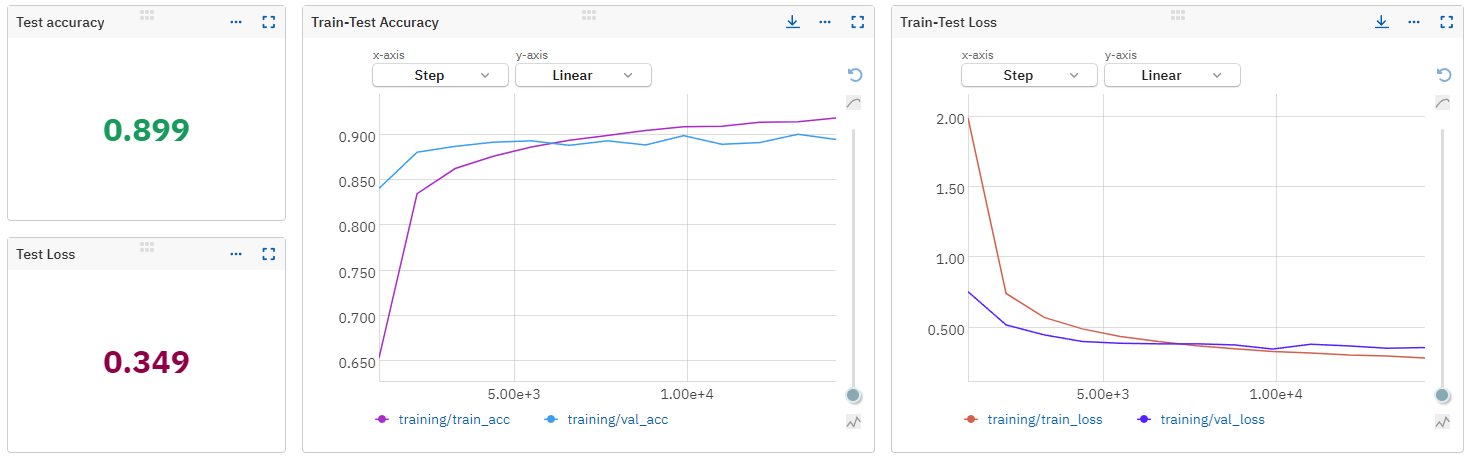

## b. DenseNet121

In [ ]:
dropout_list = [0, 0.3]
lr_list = [1e-3, 1e-4]
weight_decay_list = [0.001, 0.01]
params_list = get_params_list(dropout_list, lr_list, weight_decay_list, 'DenseNet121')
hyper_params_list_densenet = grid_search(params_list, train_df_undersample, val_df, test_df, "Densenet_grid_search",128, 10)

In [95]:
print_grid_search(hyper_params_list_densenet)


Best hyperparameters: params:
{'num_classes': 525, 'model_name': 'DenseNet121', 'dropout': 0.3}
{'lr': 0.001, 'weight_decay': 0.01},  validation loss: 1.596


Grid Search results:
params:
{'num_classes': 525, 'model_name': 'DenseNet121', 'dropout': 0}
{'lr': 0.001, 'weight_decay': 0.001},  validation loss: 1.607

params:
{'num_classes': 525, 'model_name': 'DenseNet121', 'dropout': 0}
{'lr': 0.001, 'weight_decay': 0.01},  validation loss: 1.625

params:
{'num_classes': 525, 'model_name': 'DenseNet121', 'dropout': 0}
{'lr': 0.0001, 'weight_decay': 0.001},  validation loss: 5.169

params:
{'num_classes': 525, 'model_name': 'DenseNet121', 'dropout': 0}
{'lr': 0.0001, 'weight_decay': 0.01},  validation loss: 5.134

params:
{'num_classes': 525, 'model_name': 'DenseNet121', 'dropout': 0.3}
{'lr': 0.001, 'weight_decay': 0.001},  validation loss: 1.615

params:
{'num_classes': 525, 'model_name': 'DenseNet121', 'dropout': 0.3}
{'lr': 0.001, 'weight_decay': 0.01},  validation loss: 1.596

params

#### Final training with chosen Hyper-Parameters - "learing rate": 1e-3, "weight decay": 0.01 and "dropout": 0.3

In [ ]:
chosen_model_DenseNet121, model_results_DenseNet121, cp_path_new_DenseNet121, total_time_DenseNet121 = test_model(
    model_name="DenseNet121",
    cp_path = None,
    batch_size = 128,
    max_epochs = 20,
    train_df = oversample_train_df,
    val_df = test_df,
    test_df = test_df,
    model_hparams={'model_name':'DenseNet121', 'num_classes':525, 'dropout': 0.3},
    optimizer_name = "Adam",
    optimizer_hparams = {"lr": 1e-3, "weight_decay": 0.01},
)

In [29]:
print_results(model_results_DenseNet121)

Model Results:

Test Loss: 0.22483761608600616
Test Accuracy: 0.9352381229400635


In [30]:
torch.save(chosen_model_DenseNet121, "/kaggle/working/DenseNet121.pth")

### run 192:

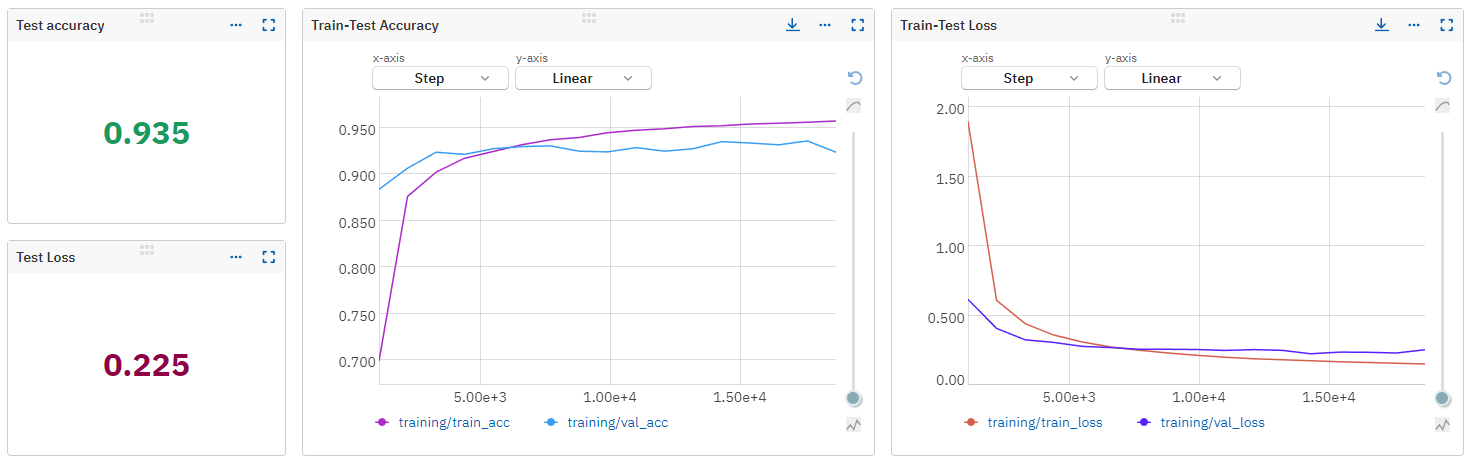

## c. Feature Extractor

In [19]:
# Read DenseNet121 model that was trained earlier
DenseNet121 = torch.load('/kaggle/input/densenet121/DenseNet121.pth')

# Concatenate train_df and val_df
train_df = pd.concat([train_df, val_df], ignore_index=True)

# Resetting index (optional)
train_df.reset_index(drop=True, inplace=True)

# Oversampling train df
oversample_train_df = oversample_df(train_df)

# Select relevant columns
oversample_train_df = oversample_train_df[['filepaths', 'class']]
test_df = test_df[['filepaths', 'class']]

In [20]:
# Define lists to store features and labels
all_features = []
all_labels = []

# Remove linear layer from the pre-trained model
FE_model = torch.nn.Sequential(*(list(DenseNet121.features.children())[:-1]))

# Utilize multiple GPUs 
FE_model = torch.nn.DataParallel(FE_model, device_ids=[0, 1])

# Set model to evaluation mode
FE_model.eval()

# Move model to device (CPU or GPU)
FE_model.to(device)

# Instantiate BirdsDataModule for data loading
dm = BirdsDataModule(oversample_train_df, test_df, test_df, 128)

# Iterate through training data loader to extract features
with torch.no_grad():
    for inputs, labels in tqdm(dm.train_dataloader()):
        # Move inputs and labels to device
        inputs = inputs.to(device)
        labels = labels.to(device)
        
        # Extract features using the pre-trained model
        features = FE_model(inputs)
        
        # Reshape features for compatibility and convert to numpy array
        features = features.view(features.size(0), -1)
        
        # Reduce precision for memory efficiency
        features = features.half().cpu().numpy()  
        labels = labels.half().cpu().numpy()
        
        # Convert labels to numpy array and store features and labels
        all_features.append(features)
        all_labels.append(labels)
        
# Concatenate features and labels into numpy arrays
np_train_features = np.concatenate(all_features, axis=0)
np_train_labels = np.concatenate(all_labels, axis=0)

100%|██████████| 1100/1100 [06:59<00:00,  2.62it/s]


In [ ]:
# Clear memory from CPU RAM
del all_features
gc.collect()

In [36]:
features_shape = np_train_features.shape
print(f'There size of the feature matrix is {features_shape} = (n_samples, 1024*7*7)')
print('To reduce the number of columns, and do it in an efficient way, i will use IncrementalPCA.')

There size of the feature matrix is (140700, 50176) = (n_samples, 1024*7*7)
To reduce the number of columns, and do it in an efficient way, i will use IncrementalPCA.


In [22]:
# Define the number of components you want to reduce to
n_components = 50  # for example

# Initialize IncrementalPCA
ipca = IncrementalPCA(n_components=n_components)

chunk_size = 1000  
chunks = [np_train_features[i:i + chunk_size] for i in range(0, np_train_features.shape[0], chunk_size)]

for chunk in tqdm(chunks):
    ipca.partial_fit(chunk)

np_train_features_reduced = np.concatenate([ipca.transform(chunk) for chunk in chunks], axis=0)

100%|██████████| 141/141 [35:46<00:00, 15.22s/it]


In [ ]:
# Clear memory from CPU RAM
del np_train_features
gc.collect()

In [26]:
# Define lists to store features and labels
all_features = []
all_labels = []

# Iterate through training data loader to extract features
with torch.no_grad():
    for inputs, labels in tqdm(dm.test_dataloader()):
        # Move inputs and labels to device
        inputs = inputs.to(device)
        labels = labels.to(device)
        
        # Extract features using the pre-trained model
        features = FE_model(inputs)
        
        # Reshape features for compatibility and convert to numpy array
        features = features.view(features.size(0), -1)
        
        # Reduce precision for memory efficiency
        features = features.half().cpu().numpy()  
        labels = labels.half().cpu().numpy()
        
        # Convert labels to numpy array and store features and labels
        all_features.append(features)
        all_labels.append(labels)
        
# Concatenate features and labels into numpy arrays
np_test_features = np.concatenate(all_features, axis=0)
np_test_labels = np.concatenate(all_labels, axis=0)

100%|██████████| 21/21 [00:08<00:00,  2.36it/s]


In [ ]:
# Clear memory from CPU RAM
del all_features
gc.collect()

In [28]:
# Apply ipca to np_test_features
np_test_features_reduced = ipca.transform(np_test_features)

In [ ]:
# Clear memory from CPU RAM
del np_train_features
del np_test_features
gc.collect()

In [70]:
# Load data
train_features = pd.DataFrame(np_train_features_reduced)
train_labels = pd.DataFrame(np_train_labels)
test_features = pd.DataFrame(np_test_features_reduced)
test_labels = pd.DataFrame(np_test_labels)


# Initialize XGBoost classifier
model = xgb.XGBClassifier(
    objective='multi:softmax',  
    num_class=525,  # Number of classes
)

t = time.time()

# Train the classifier
model.fit(train_features, train_labels)

# Make predictions on training data
train_predictions = model.predict(train_features)

# Calculate training accuracy
train_accuracy = (train_predictions == train_labels.values.flatten()).mean()
print("Train Accuracy:", train_accuracy)

# Make predictions
predictions = model.predict(test_features)

# Evaluate accuracy
test_accuracy = (predictions == test_labels.values.flatten()).mean()
print("Test Accuracy:", test_accuracy)

total_time = time.time() - t
print("Total Time:", total_time)

Train Accuracy: 1.0
Test Accuracy: 0.584
Total Time: 2606.482590675354


In [140]:
# Save the model to a pickle file
with open('xgboost_model.pkl', 'wb') as f:
    pickle.dump(model, f)

## Compare Results

In [ ]:
# Initialize Neptune project
project = Project(
    project="odedreg/Assignment3",
    mode="read-only",
    api_token=""
)

In [139]:
def highlight_best(value):
    """
    Apply background color to cells based on certain conditions.

    Parameters:
    - value: The value of the cell.

    Returns:
    - str: A string containing CSS for setting background color.
    """

    # Check if the value is the maximum Train Acc or Test Acc
    is_max_train_acc = value == final_df['Train Acc'].max()
    is_max_test_acc = value == final_df['Test Acc'].max()

    # Check if the value is the minimum Train Loss, Test Loss, or Running Time
    is_min_train_loss = value == final_df['Train Loss'].min()
    is_min_test_loss = value == final_df['Test Loss'].min()
    is_min_running_time = value == final_df['Running Time (Minutes)'].min()

    # Set background color based on conditions
    bg_color = ''
    if is_max_train_acc or is_max_test_acc:
        bg_color = '#008000'  # Dark green
    elif is_min_train_loss or is_min_test_loss or is_min_running_time:
        bg_color = '#008000'  # Dark green

    # Return CSS for background color
    return 'background-color: {}'.format(bg_color)


# Fetch runs table and filter specific runs
runs_table = project.fetch_runs_table().to_pandas()
specific_runs_df = runs_table[runs_table['sys/id'].isin(['AS-165', 'AS-193', 'AS-192'])]

# Reverse the rows in the df
specific_runs_df = specific_runs_df.iloc[::-1].reset_index(drop=True)

# Replace 'sys/id' values with 'CNN' and 'ResNet34'
specific_runs_df.loc[specific_runs_df['sys/id'] == 'AS-165', 'sys/id'] = 'CNN-6 Layers'
specific_runs_df.loc[specific_runs_df['sys/id'] == 'AS-192', 'sys/id'] = 'DenseNet-121'
specific_runs_df.loc[specific_runs_df['sys/id'] == 'AS-193', 'sys/id'] = 'ResNet-34'


# Select desired columns and rename them
specific_runs_df = specific_runs_df[['sys/id', 'training/train_loss' , 'training/test_loss', 'training/train_acc', 'training/test_acc','sys/running_time', 'training/epoch']]
specific_runs_df = specific_runs_df.rename(columns={
    'sys/id': 'Model Name',
    'training/train_loss': 'Train Loss',
    'training/test_loss': 'Test Loss',
    'training/train_acc': 'Train Acc',
    'training/test_acc': 'Test Acc',
    'training/epoch': 'Epochs',
    'sys/running_time': 'Running Time (Minutes)'
})

# Create a DataFrame to hold the XGBoost model's accuracy
xgboost_df = pd.DataFrame({
    'Model Name': ['XGBoost'],
    'Train Loss': [None],
    'Test Loss': [None],
    'Train Acc': [train_accuracy],
    'Test Acc': [test_accuracy],
    'Running Time (Minutes)': [total_time],
    'Epochs': [None],
})

# Concatenate the XGBoost accuracy DataFrame with specific_runs
final_df = pd.concat([specific_runs_df, xgboost_df], ignore_index=True)

final_df.reset_index(drop=True, inplace=True)
final_df['Running Time (Minutes)'] = final_df['Running Time (Minutes)'] / 60

# Get DataFrame values
final_df_values = final_df.values

# Apply style to relevant columns
final_df_style = pd.DataFrame(final_df_values, columns=final_df.columns).style.applymap(highlight_best, subset=['Train Acc', 'Test Acc', 'Train Loss', 'Test Loss', 'Running Time (Minutes)'])

final_df_style

**Conclusions:**

* DenseNet-121 achieved the highest accuracy as expected, with an impressive score of 93.5%. This result aligns with my anticipation, considering DenseNet-121's complexity. Notably, the training accuracy reached 95.7%, indicating that further complexity in the model architecture might have led to a closer approximation to the benchmark of 99%. 

* Utilizing transfer learning accelerated the training process of a large network like DenseNet-121, enabling it to achieve commendable results within a relatively short timeframe.

* Interestingly, with just 6 layers, model 'CNN-6 Layers' performed remarkably well, achieving a similar accuracy to ResNet-34, a more complex architecture. 

* Feature extraction alone was insufficient to achieve competitive performance. 

* The discrepancy in the number of epochs can be attributed to early stopping, indicating efficient training convergence.